### CMIP5 Future FWI

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
#import xesmf as xe 

# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from collections import Counter


In [3]:
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]

In [27]:

def proj_1960(models, lon_max, lon_min, lat_min, lat_max):

    average_array = []
    for model in models:
        filein = "/data/keeling/a/davidcl2/d/MACA/FWI_RHmin/rcp45/out/macav2metdata_fwi_" + model + "_r1i1p1_rcp45_2056_2060_CONUS_daily.nc"
        #filein = "/data/keeling/a/davidcl2/d/MACA/FWI_RHmin/rcp45/out/macav2metdata_fwi_" + model + "_r1i1p1_rcp45_2086_2090_CONUS_daily.nc"

        # this code selects lon, lat, and days included, also need to include years, 
        current_model = xr.open_dataset(filein)
        selected_ds = current_model.sel(time=slice(f'{2060}-06-01', f'{2060}-10-31'))
        # This changes the lon and lat to appropraite boundaries for nevada and california 
        selected_ds["lon"] = np.where(selected_ds["lon"] > 180, selected_ds["lon"] - 360, selected_ds["lon"])
        selected_ds = selected_ds.sortby("lon")
        annual_mean = selected_ds.where((selected_ds.lon >= lon_min) & (selected_ds.lon <= lon_max) & (selected_ds.lat >= lat_min) & (selected_ds.lat <= lat_max), drop=True)

        current_model = annual_mean

        # this is where analysis starts after cleaning, all I need is the 2060 spatial aggregate for each model at each location
        spatial_aggregate = current_model.mean(dim=['time'])
        average_array.append(spatial_aggregate)
        
        
        print("iteration " + model)

    return average_array

    
    

In [28]:
fwi_array = proj_1960(models, -114.016667, -124.766667, 32.025, 50)

iteration BNU-ESM
iteration CNRM-CM5
iteration CSIRO-Mk3-6-0
iteration CanESM2
iteration GFDL-ESM2G
iteration GFDL-ESM2M
iteration HadGEM2-CC365
iteration HadGEM2-ES365
iteration IPSL-CM5A-LR
iteration IPSL-CM5A-MR
iteration IPSL-CM5B-LR
iteration MIROC-ESM-CHEM
iteration MIROC-ESM
iteration MIROC5
iteration bcc-csm1-1-m
iteration MRI-CGCM3
iteration bcc-csm1-1
iteration inmcm4


In [29]:
concatenated_data = xr.concat(fwi_array, dim='array')
average_2060_proj = concatenated_data.mean(dim='array')


### Plotting CMIP5 Ensemble Average FWI

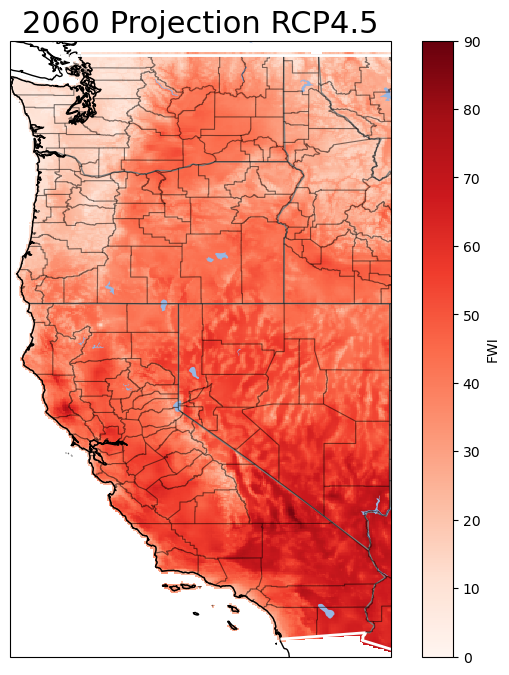

In [30]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())
#counties
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

shapefile_path = '/data/keeling/a/ctavila2/4_Model_Trendline/shape/ne_10m_ocean.shp'
gdf_ocean = gpd.read_file(shapefile_path)

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')

cmap='Reds'

# central_longitude=260.0
## (17,17)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
#print(booted_trend_slope)
average_2060_proj.FWI.plot(ax=ax,cmap=cmap,vmin=0,vmax=90)

# Set the aspect ratio to 'box' for horizontal stretching
# Replace min_x and max_x with appropriate values# Plot the second shapefile (gdf_wgs84)
# Replace 'white' and 'black' with the desired colors and styling

#gdf_wgs84.boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=1.0)

# Set the extent and add other map features as needed
#ax.set_extent([-125, -113, 31.5, 49.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')

#gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
#gl.xlabel_style = {'size': 10, 'color': 'black'}
#gl.ylabel_style = {'size': 10, 'color': 'black'}

#gdf_ocean.plot(ax=ax, color='white', edgecolor='white', linewidth=1.0)

plt.title('2060 Projection RCP4.5', fontsize=22)
plt.savefig('/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_2_2060_2090_spatial_fwi_v2/3_1_2_CMIP5_2060_Average_FWI_Projection_tmaxrhmin_native_rcp45_90a')
